In [1]:
import os
import cv2
import numpy as np
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-06-16 17:23:31.970639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 17:23:31.970906: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 17:23:31.973474: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 17:23:32.009682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 17:23:32.740921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
DATADIR = "dataset/train/"
CATEGORIES = ["lajthiza", "spring", "tepelena"]

# Defining the size of the images expected by MobileNetV2
IMG_SIZE = 224

# Loading images directly from the dataset folder and preprocess them
def load_images():
    X = []
    y = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            if img.endswith(".jpg"):  # Ensure only .jpg files are processed
                try:
                    img_path = os.path.join(path, img)
                    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                    image = img_to_array(image)
                    image = preprocess_input(image)
                    X.append(image)
                    y.append(class_num)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    return np.array(X), np.array(y)

# Loading the images and labels
X, y = load_images()

# Verifying the shape of the loaded data
print(f"Loaded images shape: {X.shape}")
print(f"Loaded labels shape: {y.shape}")


Loaded images shape: (969, 224, 224, 3)
Loaded labels shape: (969,)


In [3]:
num_classes = len(np.unique(y))  # Automatically determine number of classes
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Spliting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifying data shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (775, 224, 224, 3)
y_train shape: (775, 3)
X_val shape: (194, 224, 224, 3)
y_val shape: (194, 3)


In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freezing the base model
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [5]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluating the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 789ms/step - accuracy: 0.7462 - loss: 0.6861 - val_accuracy: 1.0000 - val_loss: 0.0174
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 678ms/step - accuracy: 0.9880 - loss: 0.0472 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 648ms/step - accuracy: 0.9988 - loss: 0.0165 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 673ms/step - accuracy: 0.9997 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 607ms/step - accuracy: 0.9952 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 663ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 9.5838e-04
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 5.9480e-04
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step - accuracy: 1.0000 - loss: 0.0028 - 

In [19]:
model.save('water_bottle_classifier_mobilenetv2_pretrained.h5')

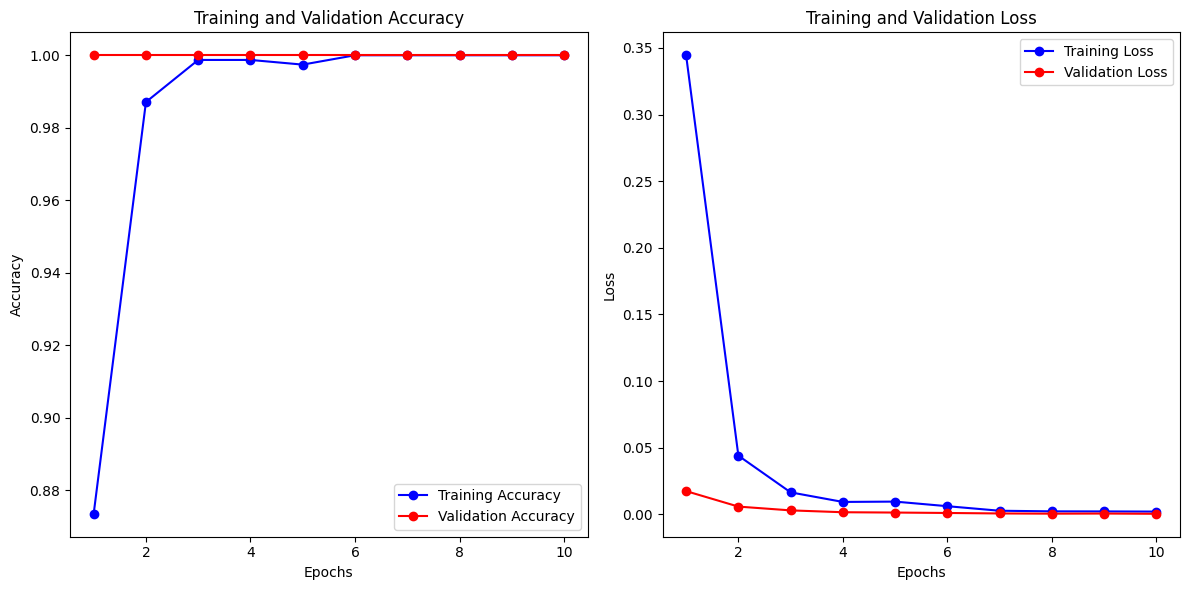

In [6]:
epochs = range(1, 11)

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()